## **Example (1D)**

### **Set Environment**

In [1]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, InnerProductProcessor
from lib.QuantumOptimizer import VQA_PoissonOptimizer1D
from lib.classical_functions import *
from lib.quantum_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# IonQ Simulator
os.environ['IONQ_API_KEY'] = 'BU5YwsZpbahvhbxSOEc9qMCvyCqhmxq8'
provider = IonQProvider(os.getenv("IONQ_API_KEY"))
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

# IBM Hardware
hardware_backend = QiskitRuntimeService().least_busy()
print(hardware_backend.name)

ibm_yonsei


### **Initialize Sampler**

In [2]:
grid_num = 16
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Design Ansatz**

Number of Parameters: 16


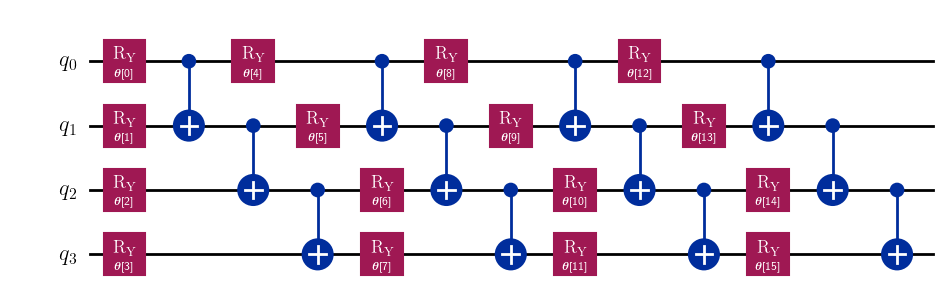

In [3]:
num_qubits = int(np.log2(grid_num))
num_qubits1D = int(num_qubits / 2)
ansatz_depth = 4
param_num = num_qubits * ansatz_depth
parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

psi_param_circuit = make_LNN_ansatz(num_qubits, ansatz_depth, parameters)
print(f"Number of Parameters: {param_num}")
psi_param_circuit.draw('mpl', fold = -1)

### **Define Source Function**

In [4]:
f = np.array([np.sin(2 * np.pi * i / grid_num) for i in range (grid_num)])
f_normalized = f / np.linalg.norm(f)
dx = 1 / grid_num

### **Initialize Processors**

In [5]:
laplacian_processor = LaplacianEVProcessor1D(
    ansatz_list=[psi_param_circuit],
    boundary_condition_list=['P'],
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

numerator_processor = InnerProductProcessor(
    ansatz_list=[psi_param_circuit],
    numerator_list = [f_normalized],
    backend=simulator_backend,
    num_shots=num_shots,
    is_simulator=True,
)

### **Conduct Optimization**

In [6]:
optimizer = VQA_PoissonOptimizer1D(
    laplacian_processor = laplacian_processor,
    numerator_processor = numerator_processor,
    dx = dx,
    ansatz = psi_param_circuit
)

initial_params = np.random.rand(param_num) * 4 * np.pi
result = optimizer.optimize(initial_params = initial_params)

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.011624365818608944
       x: [ 5.160e+00  8.209e+00 ...  1.209e+01  7.012e+00]
    nfev: 227
   maxcv: 0.0

### **Read ansatz**

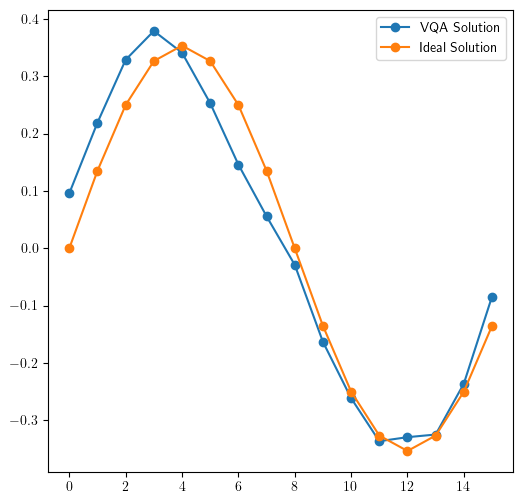

In [14]:
optimal_params = result.x
optimal_state = make_classical_psi(num_qubits, ansatz_depth, optimal_params).real

plt.figure(figsize = (6,6))
plt.plot(optimal_state, marker = 'o', label = 'VQA Solution')
plt.plot(f_normalized, marker = 'o', label = 'Ideal Solution')
plt.legend()
plt.show()